In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import vgg16, imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import string
# image processing
from PIL import Image
# get file name with condotion
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape
from keras.layers import concatenate, Dropout, BatchNormalization
from keras.optimizers import adam_v2, rmsprop_v2
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# A binary matrix representation of the input. The class axis is placed last.
from tensorflow.keras.utils import to_categorical

In [ ]:
# Doc file cac caption
def load_doc(filename):
  # opem the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file 
  file.close()
  return text

filename = "Flickr8k/Flicker8k_text/Flickr8k.token.txt"

doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
# luu caption duoi dang key value:
# id_image : ["caption1", "caption2", "caption3", "caption 4", "caption5"]
def load_descriptions(doc):
  mapping = dict()
  # processing lines
  for line in doc.split("\n"):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description   
    image_id, image_desc = tokens[0], tokens[1:]
    # extract filename from image id
    image_id = image_id.split('.')[0]
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    # creat the list if needed
    if image_id not in mapping:
      mapping[image_id]= list()
    #store description 
    mapping[image_id].append(image_desc)
  
  return mapping

descriptions = load_descriptions(doc)
print('load: %d' %len(descriptions))

descriptions['1000268201_693b08cb0e']

load: 8092


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocessing text
def clean_descriptions(description):
  # prepare translation table for removing punctuation
  # loai bo dau cau
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in description.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # convert to lower case
      desc = desc.lower()
      # tokenize
      desc = desc.split()
      # remove punctualtion fro each token
      desc = [w.translate(table) for w in desc]
      # remode hanging 's' and 'a'
      desc = [word for word in desc if len(word) > 1]
      # remove tokens withs numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] = ' '.join(desc)
# clearn desciptions
clean_descriptions(descriptions)

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# luu description xuong file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
  
save_descriptions(descriptions, 'description.txt')

In [ ]:
# lay id anh tuong ung voi du lieu train, test, dev
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # processing line by line
  for line in doc.split("\n"):
    # skip empty lines
    if len(line) < 1:
      continue 
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

# load training dataset (6K)
filename = 'Flickr8k/Flicker8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' %len(train))

# Folder chua du lieu anh
images = 'Flickr8k/Flicker8k_Dataset/'
# lay cac anh jpg trong thu muc
img = glob.glob(images + "*.jpg")

# file chua cac id anh de train
train_images_file = 'Flickr8k/Flicker8k_text/Flickr_8k.trainImages.txt'
# read the train image names in a set 
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# creat a list of all the training images with their full path names
train_img = []
for i in img: # list of full path names of all images
  if i[len(images):] in train_images: # check if image belongs to training set
    train_img.append(i)   # add it to the list of train images
  
# File chứa các id ảnh để test
test_images_file = 'Flickr8k/Flicker8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Create a list of all the test images with their full path names
test_img = []
for i in img: # img is list of full path names of all images
  if i[len(images):] in test_images: # Check if the image belongs to test set
    test_img.append(i) # Add it to the list of test images

Dataset: 6000


In [ ]:
# them startseq va endseq cho chuoi
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white apace 
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap descirption in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      #store
      descriptions[image_id].append(desc)
  return descriptions

# desciptions
train_descriptions = load_clean_descriptions('description.txt', train)
print('Desciptions: train= %d' %len(train_descriptions))
print(train_descriptions['1000268201_693b08cb0e'])

Desciptions: train= 6000
['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [ ]:
# load anh, resize ve kich thuoc ma InceptionV3 yeu cau
def preprocess(image_path):
  # convert add th image to soze 299*299 as expected by the inception v3 model
  img = image.load_img(image_path, target_size=(299, 299))
  # convert PIL image to numpy array of 3 dimention
  x = image.img_to_array(img)
  # add one more dimention
  x = np.expand_dims(x, axis=0)
  # preprocess th image using preprocess_input() from inception model
  x = preprocess_input(x)
  return x
# load the inception v3 model
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
# toa model moi bo layer cuoi tu inception v3
model_new = Model(model.input, model.layers[-2].output)

#image embedding thanh vecto (2048,)
def encode(image):
  image = preprocess(image) # preprocess th image
  fea_vec = model_new.predict(image) # get the encode=ing vecto of th image
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
  return fea_vec

# goi ham encode voi cac hinh anh trong training set
start = time()
encoding_train = {}
for img in train_img:
  encoding_train[img[len(images):]] = encode(img)

print("time taken in seconds", time() - start)

time taken in seconds 3441.1516919136047


In [ ]:
encoding_train["1000268201_693b08cb0e.jpg"]

In [ ]:
# luu image embedding lai
with open("Flickr8k/Pickle/encoded_train_images.pkl",'wb') as encoded_pickle:
  dump(encoding_train, encoded_pickle)

# encode test image
start = time()
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images):]] = encode(img)
print("time takens in seconds = ", time()-start)
# save th bottleneck test features to disk
with open("Flickr8k/Pickle/encoded_test_images.pkl",'wb') as encoded_pickle:
  dump(encoding_test, encoded_pickle)

time takens in seconds =  572.8193049430847


In [ ]:
with open("Flickr8k/Pickle/encoded_train_images.pkl", "rb") as f:
  train_features = load(f)

print('Photos: train=%d' % len(train_features))

# tao list cac traing caption
all_train_captions = []
for key, val in train_descriptions.items():
  for cap in val:
    all_train_captions.append(cap)

len(all_train_captions)

# chi lay cac tu xuat hien tren 10 lan
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0)  + 1

vocab = [ w for w in word_counts if word_counts[w] >= word_count_threshold]
print("preprocessed word %d -> %d" % (len(word_counts), len(vocab)))

Photos: train=6000
preprocessed word 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1

vocab_size = len(ixtoword) + 1 # them 1 cho tu dung de padding
vocab_size

1652

In [ ]:
# convert a dictionary of clearn description to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

# caculate the length of the description with the most words
def max_length(desciptions):
  lines = to_lines(desciptions)
  return max(len(d.split()) for d in lines)

# determine the maximum sequens length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator cho viec train theo tung batch mode.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  n = 0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n += 1
      # retrieve the photo feature
      # lay lai 
      photo = photos[key+ '.jpg']
      for desc in desc_list:
        # encode the sequence
        seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
        # split one sequence into multiple X, y pairs (cap)
        for i in range(1, len(seq)):
          #split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq  = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sepuence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
        # yield the batch data
        if n==num_photos_per_batch:
          yield [[np.array(X1), np.array(X2)], np.array(y)]
          X1, X2, y = list(), list(), list()
          n = 0


In [ ]:
# load Glove model
glove_dir = ''
embeddings_index = {} #empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding='utf-8')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.array(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('Found %s word vector' % len(embeddings_index))

embedding_dim = 200

Found 400000 word vector


In [ ]:
# get 200 dim desce vector for each of the 1000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 

for word, i in wordtoix.items():
  # if i < max_words:
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in the embedding index will be all zeros
    embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 200)

In [ ]:
from keras import Input, layers
# tao model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
# layer2 dung Glove Model nen set weight thang khong can train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
  generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


1000/1000 [==============================] - 679s 679ms/step - loss: 3.3723


In [ ]:
model.save_weights('./model_30.h5')

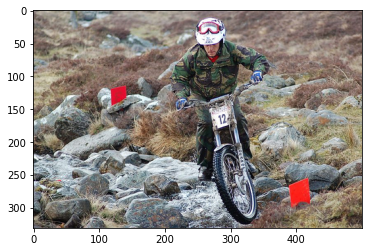

man in red shirt is riding bike on dirt path


In [ ]:
images = 'Flickr8k/Flicker8k_Dataset/'

with open("Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
  encoding_test = load(encoded_pickle)

# Với mỗi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi
# sau đó cho vào model để dự đoán từ tiếp theo.
# Ta thêm từ vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq'
# là kết thúc hoặc cho đến khi chuỗi dài 34 từ.

def greedySearch(photo):
  in_text = 'startseq'
  for i in range(max_length):
    sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = ixtoword[yhat]
    in_text += ' ' + word
    if word == 'endseq':
      break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final
  
z=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))
